In [1]:
import torch
import numpy as np
import os
os.chdir('..')

import torch_converter as tc
import instance_generator as ig
from torch_geometric.loader import DataLoader
from gnn_library.util import train, save, load
from util import NumpyDataset, Dataset
from evaluate import evaluate_model, pp_output
import evaluate as ev
from gnn_library.OBM_greedy import OBM_Greedy
#import evaluate as ev

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda:2' if torch.cuda.is_available() else 'cpu')
print("PyTorch has version {}".format(torch.__version__))
print('Using device:', device)

PyTorch has version 2.0.0+cu117
Using device: cuda:2


In [3]:
GNN1, args1 = load('GNN1', device)
GNN2, args2 = load('GNN2', device)
GREEDY = OBM_Greedy()

In [22]:
er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

avg_ratios = []
epsilons = [0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
for epsilon in epsilons:
    rng = np.random.default_rng()

    instances = [
        # *ig.sample_instances(6, 10, 100, rng, **er_config),
        # *ig.sample_instances(6, 10, 100, rng, **ba_config),
        # # *ig.sample_instances(6, 10, 100, rng, **geom_config),
        # *ig.sample_instances(8, 8, 100, rng, **er_config),
        # *ig.sample_instances(8, 8, 100, rng, **ba_config),
        # *ig.sample_instances(8, 8, 100, rng, **geom_config),
        *ig.sample_instances(10, 6, 100, rng, **er_config),
        *ig.sample_instances(10, 6, 100, rng, **ba_config),
        *ig.sample_instances(10, 6, 100, rng, **geom_config)
    ]

    ratios = ev.evaluate_shakey_opt(
        epsilon=epsilon,
        base_models=[GNN1, GNN2, GREEDY],
        instances=instances,
        batch_size=50,
        rng=rng,
        num_realizations=10
    )

    avg_ratios.append(np.mean(ratios[0]).round(4))

    

Text(0.5, 1.0, '(m, n) = (10, 6)')

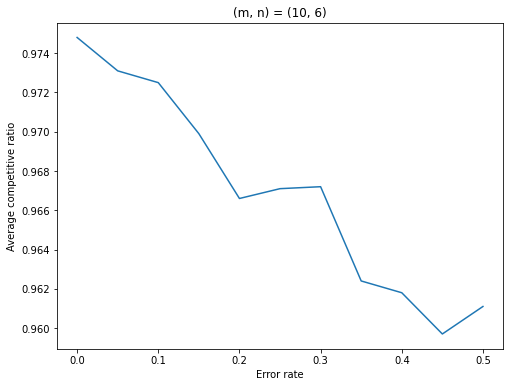

In [23]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8, 6))
plt.plot(epsilons, avg_ratios)
plt.xlabel('Error rate')
plt.ylabel('Average competitive ratio')
plt.title('(m, n) = (10, 6)')

### I. Meta GNN training/evaluation

In [50]:
args = {
    'processor':         'TEST',
    'head':              'meta',
    'num_layers':        2,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        12,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        64,
    'output_dim':        3,
    'dropout':           0.25,
    'epochs':            25,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 25; test_num = 5

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = Dataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GREEDY, GNN2]
    )
)

test_data = Dataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='gnn',
        base_models=[GNN1, GREEDY, GNN2]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [57]:
args = {
    'processor':         'TEST',
    'head':              'meta',
    'num_layers':        2,
    'aggr':              'max',
    'batch_size':        12,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        1,
    'output_dim':        3,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.01,
    'device':            device
}

In [58]:
sum = torch.zeros(3)
for data in train_data:
    sum += data.hint

print(sum)

tensor([613., 512., 525.])


In [59]:
_, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/50 [00:00<?, ?Epochs/s]

1.1000177166678689


Training:   2%|▏         | 1/50 [00:03<03:08,  3.84s/Epochs]

TEST ACCURACY: 0.41566264629364014
TEST LOSS: 1.0826165676116943


Training:   4%|▍         | 2/50 [00:06<02:43,  3.40s/Epochs]

1.0922668795152144
1.0894093764911998


Training:   6%|▌         | 3/50 [00:11<02:58,  3.80s/Epochs]

TEST ACCURACY: 0.3765060007572174
TEST LOSS: 1.0916435718536377


Training:   8%|▊         | 4/50 [00:14<02:39,  3.46s/Epochs]

1.090281869281422
1.0899225052920254


Training:  10%|█         | 5/50 [00:17<02:39,  3.54s/Epochs]

TEST ACCURACY: 0.3885542154312134
TEST LOSS: 1.0819172859191895


Training:  12%|█▏        | 6/50 [00:20<02:28,  3.37s/Epochs]

1.0901329209587791
1.0896850343184037


Training:  14%|█▍        | 7/50 [00:24<02:30,  3.49s/Epochs]

TEST ACCURACY: 0.3825300931930542
TEST LOSS: 1.0804014205932617


Training:  16%|█▌        | 8/50 [00:27<02:19,  3.33s/Epochs]

1.0895981333472513
1.0901567615162242


Training:  18%|█▊        | 9/50 [00:31<02:22,  3.48s/Epochs]

TEST ACCURACY: 0.3885542154312134
TEST LOSS: 1.0806037187576294


Training:  18%|█▊        | 9/50 [00:33<02:30,  3.68s/Epochs]


KeyboardInterrupt: 

In [73]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        1,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        12,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        1,
    'output_dim':        2,
    'head_mlp_dim':      5,
    'dropout':           0.25,
    'epochs':            200,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}

train_num = 100; test_num = 20

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, 2*train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, 2*train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, 2*train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, 2*test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, 2*test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, 2*test_num, rng, **geom_config)
]

train_data = Dataset(
    tc._instances_to_gnn_samples(
        instances=train_instances,
        head='classification',
        base_models=[GNN1, GNN2],
        batch_size=args['batch_size']
    )
)

test_data = Dataset(
    tc._instances_to_gnn_samples(
        instances=test_instances,
        head='classification',
        base_models=[GNN1, GNN2],
        batch_size=args['batch_size']
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

(array([0]), array([6000]))
(array([0]), array([6000]))
(array([0]), array([1200]))
(array([0]), array([1200]))


In [74]:
sum = torch.zeros(2)
for data in train_data:
    sum += data.hint

print(sum)

tensor([298., 628.])


In [80]:
args = {
    'processor':         'TEST2',
    'head':              'meta',
    'num_layers':        4,
    'num_mlp_layers':    2,
    'aggr':              'max',
    'batch_size':        12,
    'node_feature_dim':  4,
    'edge_feature_dim':  1,
    'graph_feature_dim': 2,
    'hidden_dim':        8,
    'output_dim':        2,
    'head_mlp_dim':      8,
    'dropout':           0,
    'epochs':            35,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

In [81]:
_, _, META_GNN, _ = train(train_loader, test_loader, args)

Training:   0%|          | 0/35 [00:00<?, ?Epochs/s]

0.6280477820668313


Training:   3%|▎         | 1/35 [00:04<02:19,  4.10s/Epochs]

TEST ACCURACY: 0.6631579399108887
TEST LOSS: 0.6328222751617432


Training:   6%|▌         | 2/35 [00:06<01:51,  3.39s/Epochs]

0.620007052663593
0.6199378206456969


Training:   9%|▊         | 3/35 [00:10<01:52,  3.52s/Epochs]

TEST ACCURACY: 0.6631579399108887
TEST LOSS: 0.6211866736412048


Training:  11%|█▏        | 4/35 [00:13<01:42,  3.31s/Epochs]

0.6127055101338009
0.6083035010755963


Training:  14%|█▍        | 5/35 [00:17<01:41,  3.39s/Epochs]

TEST ACCURACY: 0.6631579399108887
TEST LOSS: 0.6018067598342896


Training:  17%|█▋        | 6/35 [00:20<01:33,  3.24s/Epochs]

0.5990420655864361
0.6117751258495817


Training:  20%|██        | 7/35 [00:24<01:41,  3.62s/Epochs]

TEST ACCURACY: 0.6631579399108887
TEST LOSS: 0.6089125275611877


Training:  23%|██▎       | 8/35 [00:27<01:31,  3.39s/Epochs]

0.5981066145855716
0.5990909672710345


Training:  26%|██▌       | 9/35 [00:31<01:32,  3.54s/Epochs]

TEST ACCURACY: 0.6631579399108887
TEST LOSS: 0.5993701815605164


Training:  29%|██▊       | 10/35 [00:34<01:24,  3.37s/Epochs]

0.5944673585067815
0.585797459466411


Training:  31%|███▏      | 11/35 [00:38<01:24,  3.51s/Epochs]

TEST ACCURACY: 0.6631579399108887
TEST LOSS: 0.5924893617630005


Training:  34%|███▍      | 12/35 [00:41<01:16,  3.33s/Epochs]

0.5932636874412099
0.5856616956626365


Training:  37%|███▋      | 13/35 [00:44<01:15,  3.42s/Epochs]

TEST ACCURACY: 0.7842105627059937
TEST LOSS: 0.5798739194869995


Training:  40%|████      | 14/35 [00:47<01:08,  3.27s/Epochs]

0.5807307783522307
0.5809493290167905


Training:  43%|████▎     | 15/35 [00:51<01:07,  3.38s/Epochs]

TEST ACCURACY: 0.7157894968986511
TEST LOSS: 0.5761176347732544


Training:  46%|████▌     | 16/35 [00:54<01:02,  3.27s/Epochs]

0.581927933008058
0.5764675374036217


Training:  49%|████▊     | 17/35 [00:57<01:01,  3.40s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5641400814056396


Training:  51%|█████▏    | 18/35 [01:00<00:55,  3.26s/Epochs]

0.5738199433034233
0.5707430766159206


Training:  54%|█████▍    | 19/35 [01:04<00:54,  3.41s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5604206323623657


Training:  57%|█████▋    | 20/35 [01:07<00:49,  3.29s/Epochs]

0.5662402338780801
0.5634322736742172


Training:  60%|██████    | 21/35 [01:11<00:47,  3.40s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5542197823524475


Training:  63%|██████▎   | 22/35 [01:14<00:42,  3.24s/Epochs]

0.5635021301891582
0.5610134342834192


Training:  66%|██████▌   | 23/35 [01:18<00:41,  3.43s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5523189902305603


Training:  69%|██████▊   | 24/35 [01:21<00:36,  3.34s/Epochs]

0.5659515943305796
0.5606510528477943


Training:  71%|███████▏  | 25/35 [01:24<00:34,  3.44s/Epochs]

TEST ACCURACY: 0.7842105627059937
TEST LOSS: 0.5467612743377686


Training:  74%|███████▍  | 26/35 [01:27<00:29,  3.25s/Epochs]

0.5567057704307605
0.5586885094127696


Training:  77%|███████▋  | 27/35 [01:31<00:26,  3.37s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5436000823974609


Training:  80%|████████  | 28/35 [01:34<00:23,  3.36s/Epochs]

0.5606223608711111
0.5617649091757657


Training:  83%|████████▎ | 29/35 [01:38<00:21,  3.57s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5436303615570068


Training:  86%|████████▌ | 30/35 [01:41<00:17,  3.47s/Epochs]

0.5570484102415987
0.5572179944674861


Training:  89%|████████▊ | 31/35 [01:45<00:14,  3.61s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5417323112487793


Training:  91%|█████████▏| 32/35 [01:48<00:10,  3.38s/Epochs]

0.5560084921881138
0.5542724262560933


Training:  94%|█████████▍| 33/35 [01:52<00:07,  3.65s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5363842844963074


Training:  97%|█████████▋| 34/35 [01:56<00:03,  3.54s/Epochs]

0.5526281344195422
0.5577086878389313


Training: 100%|██████████| 35/35 [02:00<00:00,  3.44s/Epochs]

TEST ACCURACY: 0.800000011920929
TEST LOSS: 0.5395378470420837


In [18]:
save(META_GNN, args, 'META_GNN')

In [77]:
seed = np.random.randint(0, 500000)
(m, n) = (24, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 100, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=META_GNN,
    meta_model_type='gnn',
    base_models=[GNN1, GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=500,
    rng=rng,
    num_realizations=1
)

pp_output(ratios, _, show_log=False)

(array([0]), array([100]))
-- Competitive ratios --
GNN: 0.9568
Greedy: 0.921


(array([0]), array([100]))
-- Competitive ratios --
GNN: 0.9568
Greedy: 0.921


(array([0]), array([100]))
-- Competitive ratios --
GNN: 0.9506
Greedy: 0.921


### II. Meta NN training

In [ ]:
train_num = 200; test_num = 40

er_config = {
    'graph_type': 'ER',
    'p': 1,
    'weighted': True
}
ba_config = {
    'graph_type': 'BA',
    'ba_param': 4,
    'weighted': False
}
geom_config = {
    'graph_type': 'GEOM',
    'threshold': 0.2,
    'scaling': 1 / np.sqrt(2)
}

args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        5,
    'input_dim':         17,
    'batch_size':        4,
    'hidden_dim':        16,
    'output_dim':        2,
    'dropout':           0,
    'epochs':            50,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.0001,
    'device':            device
}


rng = np.random.default_rng()

train_instances = [
    *ig.sample_instances(6, 10, train_num, rng, **er_config),
    *ig.sample_instances(6, 10, train_num, rng, **ba_config),
    *ig.sample_instances(6, 10, train_num, rng, **geom_config),
    *ig.sample_instances(8, 8, train_num, rng, **er_config),
    *ig.sample_instances(8, 8, train_num, rng, **ba_config),
    *ig.sample_instances(8, 8, train_num, rng, **geom_config),
    *ig.sample_instances(10, 6, train_num, rng, **er_config),
    *ig.sample_instances(10, 6, train_num, rng, **ba_config),
    *ig.sample_instances(10, 6, train_num, rng, **geom_config)
]


test_instances = [
    *ig.sample_instances(6, 10, test_num, rng, **er_config),
    *ig.sample_instances(6, 10, test_num, rng, **ba_config),
    *ig.sample_instances(6, 10, test_num, rng, **geom_config),
    *ig.sample_instances(8, 8, test_num, rng, **er_config),
    *ig.sample_instances(8, 8, test_num, rng, **ba_config),
    *ig.sample_instances(8, 8, test_num, rng, **geom_config),
    *ig.sample_instances(10, 6, test_num, rng, **er_config),
    *ig.sample_instances(10, 6, test_num, rng, **ba_config),
    *ig.sample_instances(10, 6, test_num, rng, **geom_config)
]

train_data = NumpyDataset(
    tc._instances_to_train_samples(
        instances=train_instances,
        head=args['head'],
        meta_model_type='nn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

test_data = NumpyDataset(
    tc._instances_to_train_samples(
        instances=test_instances,
        head=args['head'],
        meta_model_type='nn',
        base_models=[GNN1, GNN2, GREEDY]
    )
)

train_loader = DataLoader(
    train_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

test_loader = DataLoader(
    test_data,
    batch_size=args['batch_size'],
    shuffle=True,
    num_workers=4
)

In [ ]:
ex = test_data[0]
example = (ex[0].to('cuda:2'), ex[1].to('cuda:2')) 

In [ ]:
args = {
    'processor':         'NN',
    'head':              'meta',
    'num_layers':        2,
    'input_dim':         23,
    'batch_size':        10,
    'hidden_dim':        8,
    'output_dim':        3,
    'dropout':           0,
    'epochs':            100,
    'opt':               'adam',
    'opt_scheduler':     'none',
    'opt_restart':       0,
    'weight_decay':      5e-3,
    'lr':                0.001,
    'device':            device
}

_, _, META_NN, _ = train(train_loader, test_loader, args)

In [10]:
seed = np.random.randint(0, 50000)
(m, n) = (8, 16)
config = er_config

rng = np.random.default_rng(seed)
eval_instances = ig.sample_instances(m, n, 10, rng, **config)

rng = np.random.default_rng(seed)
ratios1 = evaluate_model(
    meta_model=META_NN,
    meta_model_type='nn',
    base_models=[GNN1, GNN2, GREEDY],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios1, _, show_log=False)
print()
print()

rng = np.random.default_rng(seed)

ratios2 = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN1],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios2, _, show_log=False)

print()
print()

rng = np.random.default_rng(seed)

ratios = evaluate_model(
    meta_model=None,
    meta_model_type=None,
    base_models=[GNN2],
    instances=eval_instances,
    batch_size=50,
    rng=rng,
    num_realizations=5
)

pp_output(ratios, _, show_log=False)

NameError: name 'META_NN' is not defined

In [ ]:
torch.tensor([1,2]) + 3

In [82]:
num_trials = 25
node_configs = [(x, 16) for x in np.arange(4, 64, 4)]
# of nodes [20 -> 80]
# of nodes in batch [10,000 -> 40,000]
batch_size = 500 #[int(min(32, x + y)) for (x, y) in node_configs]
graph_configs = [
    # {
    #     'graph_type': 'GM'
    # },
    {
        'graph_type': 'ER',
        'p': 0.75,
        'weighted': True
    },
    {
        'graph_type': 'BA',
        'ba_param': 4,
        'weighted': True
    },
    {
        'graph_type': 'GEOM',
        'threshold': 0.2,
        'scaling': 1 / np.sqrt(2),
    }
]

ratios = [x/y for (x,y) in node_configs]
print(ratios)
data = {config['graph_type']: [] for config in graph_configs}
for graph_config in graph_configs:
    for i, node_config in enumerate(node_configs):
        print(graph_config, node_config)
        seed = np.random.randint(0, 500000)
        rng = np.random.default_rng(seed)
        instances = ig.sample_instances(*node_config, num_trials, rng, **graph_config)

        rng = np.random.default_rng(seed)
        (meta_learned_ratios, _) = evaluate_model(
            meta_model=META_GNN,
            meta_model_type='gnn',
            base_models=[GNN1, GNN2, GREEDY],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn1_learned_ratios, greedy_ratios = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN1],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )

        rng = np.random.default_rng(seed)
        gnn2_learned_ratios, _ = evaluate_model(
            meta_model=None,
            meta_model_type=None,
            base_models=[GNN2],
            instances=instances,
            batch_size=batch_size,
            rng=rng,
            num_realizations=5
        )


        data[graph_config['graph_type']].append(np.array(
            [
                meta_learned_ratios,
                gnn1_learned_ratios,
                gnn2_learned_ratios,
                greedy_ratios
            ]
        ))

[0.25, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75]
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (4, 16)
(array([1]), array([125]))
(array([0]), array([125]))
(array([0]), array([125]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (8, 16)
(array([1]), array([125]))
(array([0]), array([125]))
(array([0]), array([125]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (12, 16)
(array([1]), array([125]))
(array([0]), array([125]))
(array([0]), array([125]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (16, 16)
(array([1]), array([125]))
(array([0]), array([125]))
(array([0]), array([125]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (20, 16)
(array([1]), array([125]))
(array([0]), array([125]))
(array([0]), array([125]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (24, 16)
(array([0, 1]), array([114,  11]))
(array([0]), array([125]))
(array([0]), array([125]))
{'graph_type': 'ER', 'p': 0.75, 'weighted': True} (28, 16)
(array([0])

ER


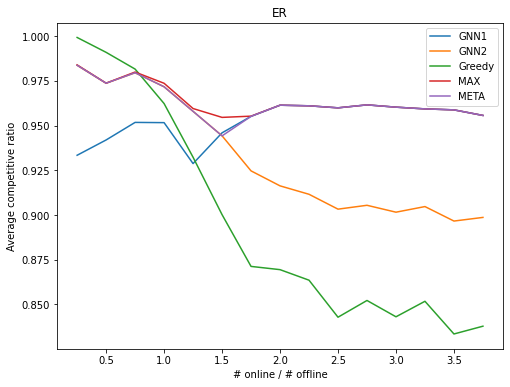

BA


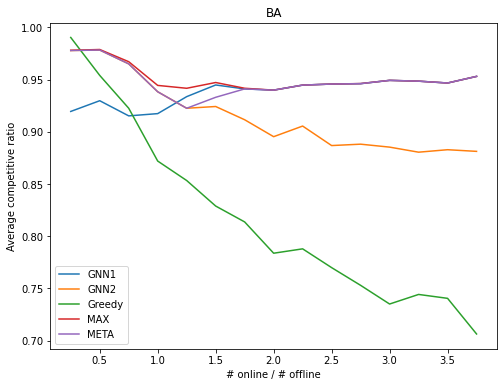

GEOM


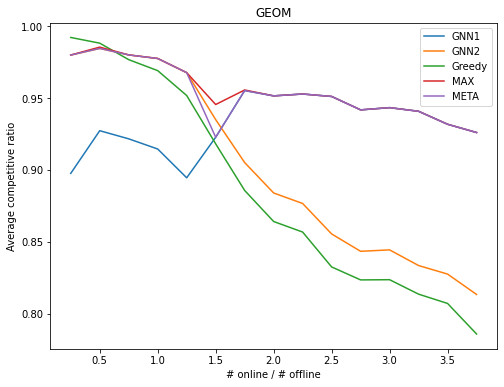

In [83]:
import matplotlib.pyplot as plt
ratios = [x/y for (x,y) in node_configs]
for graph_type, comp_ratios in data.items():
    greedy_avg_ratios = []
    meta_avg_ratios = []
    gnn1_avg_ratios = []
    gnn2_avg_ratios = []
    gnn3_avg_ratios = []
    max_avg_ratios = []

    for trial_ratios in comp_ratios:
        meta_avg_ratios.append(np.array(trial_ratios[0]).mean())
        gnn1_avg_ratios.append(np.array(trial_ratios[1]).mean())
        gnn2_avg_ratios.append(np.array(trial_ratios[2]).mean())
        #gnn3_avg_ratios.append(np.array(trial_ratios[3]).mean())
        greedy_avg_ratios.append(np.array(trial_ratios[3]).mean())
        max_avg_ratios.append(np.array(np.max(trial_ratios[1:3, :], axis=0)).mean())

    print(graph_type)
    fig = plt.figure(figsize=(8,6))
    plt.title(graph_type)
    plt.plot(ratios, gnn1_avg_ratios, label='GNN1')
    plt.plot(ratios, gnn2_avg_ratios, label='GNN2')
    #plt.plot(ratios, gnn3_avg_ratios, label='GNN3')
    plt.plot(ratios, greedy_avg_ratios, label='Greedy')
    plt.plot(ratios, max_avg_ratios, label='MAX')
    plt.plot(ratios, meta_avg_ratios, label='META')
    plt.xlabel('# online / # offline')
    plt.ylabel('Average competitive ratio')
    plt.legend()
    plt.show()


In [ ]:
comp = np.vstack([gnn1_learned_ratios, gnn2_learned_ratios, greedy_ratios]).T
comp[:10]

In [ ]:
print(np.max(comp[:2, :], axis=1).mean())
print(comp.mean(axis=0))

In [ ]:
index1 = np.argmax(comp[:, 0] - comp[:, 1])
index2 = np.argmax(comp[:, 1] - comp[:, 0])

In [ ]:
tc._featurize(instances[index1])

In [ ]:
tc._featurize(instances[index2])

In [ ]:
GNN2_features = []
GNN1_features = []
for i, boolean in enumerate(comp[:, 1] > comp[:, 0]):
    if boolean:
        GNN2_features.append(tc._featurize(instances[i]))
    else:
        GNN1_features.append(tc._featurize(instances[i]))

out1 = np.vstack(GNN1_features)
out2 = np.vstack(GNN2_features)


In [ ]:
out1.mean(axis=0)

In [ ]:
out2.mean(axis=0)